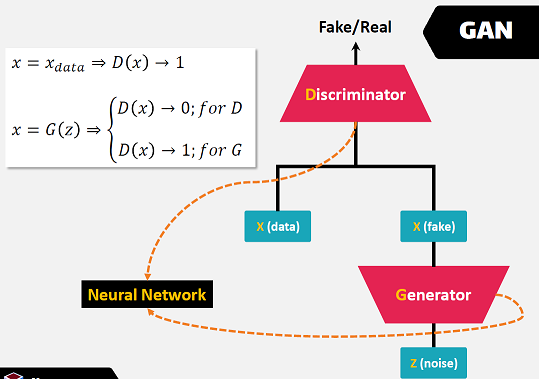

In [1]:
lr = 3e-4
input_genrator = 20 # less than input features or output generator
input_features = 41 # or output generator
batch_size = 4000
num_epochs = 50

hidden_size = 16 #number of features in hidden state
num_layers = 3  #number of stacked lstm layers
bidirectional = True
drop_out = 0
bidirectional_forward_backward = 2 if bidirectional else 1

hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.autograd import Variable 

device = "cuda" if torch.cuda.is_available() else "cpu"

def plot_history(d_hist, g_hist):
    plt.plot(d_hist, label='Discriminator')
    plt.plot(g_hist, label='Generator')
    plt.legend(['Discriminator','Generator'])
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        # print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        
        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self,data_set_path):
        df = pd.read_csv(data_set_path)
        # print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

# **create Generator and Discriminator**

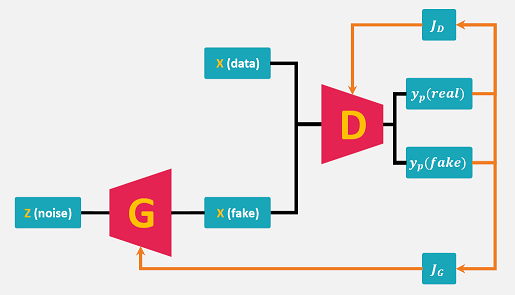

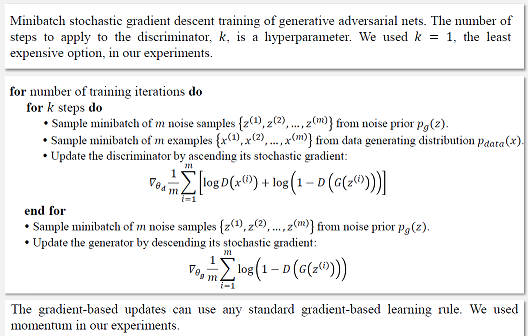

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        self.num_layers = num_layers #number of layers
        self.input_size = in_features #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=in_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=drop_out) #lstm

        self.fc_layers = nn.Sequential(
        nn.LeakyReLU(0.01),
        nn.Linear(hidden_size * bidirectional_forward_backward, hyper_parameter1),
        nn.LeakyReLU(0.01),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.LeakyReLU(0.01),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.LeakyReLU(0.01),
        nn.Linear(hyper_parameter3, 1),
        nn.Sigmoid(),
        )

        #  nn.Sequential(
        #     nn.Linear(in_features, 128),
        #     nn.LeakyReLU(0.01),
        #     nn.Linear(128, 1),
        #     nn.Sigmoid()
        # )

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers * bidirectional_forward_backward, x.size(0), self.hidden_size)).to(device=device) #internal state

        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.fc_layers(out[:, -1, :]) 
        return out

class Generator(nn.Module):
    def __init__(self, input_genrator, output_generator_or_in_features):
        super().__init__()

        self.gen = nn.Sequential(
              nn.Linear(input_genrator, hyper_parameter4),
              nn.LeakyReLU(0.01),
              nn.Linear(hyper_parameter4, hyper_parameter3),
              nn.LeakyReLU(0.01),
              nn.Linear(hyper_parameter3, hyper_parameter2),
              nn.LeakyReLU(0.01),
              nn.Linear(hyper_parameter2, hyper_parameter1),
              nn.LeakyReLU(0.01),
              nn.Linear(hyper_parameter1,output_generator_or_in_features)
              )

        # self.gen = nn.Sequential(
        #     nn.Linear(input_genrator, 256),
        #     nn.LeakyReLU(0.01),
        #     nn.Linear(256, in_features),
        #     # nn.Tanh()  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        # )

    def forward(self, x):
        return self.gen(x)

# **attack category**

Epoch [0/50] loss D: 0.6934, loss G: 0.6723
Epoch [1/50] loss D: 0.6917, loss G: 0.6956
Epoch [2/50] loss D: 0.6957, loss G: 0.7600
Epoch [3/50] loss D: 0.4304, loss G: 1.0783
Epoch [4/50] loss D: 0.7511, loss G: 1.0691
Epoch [5/50] loss D: 0.6759, loss G: 0.9523
Epoch [6/50] loss D: 0.4015, loss G: 0.9890
Epoch [7/50] loss D: 0.6279, loss G: 1.0244
Epoch [8/50] loss D: 0.6985, loss G: 0.7795
Epoch [9/50] loss D: 0.4505, loss G: 1.0071
Epoch [10/50] loss D: 0.4683, loss G: 1.6604
Epoch [11/50] loss D: 0.3643, loss G: 1.7540
Epoch [12/50] loss D: 0.2830, loss G: 2.3568
Epoch [13/50] loss D: 0.4427, loss G: 1.2436
Epoch [14/50] loss D: 0.3510, loss G: 1.5801
Epoch [15/50] loss D: 0.3427, loss G: 1.6975
Epoch [16/50] loss D: 0.2116, loss G: 1.6330
Epoch [17/50] loss D: 0.3288, loss G: 1.5712
Epoch [18/50] loss D: 0.3043, loss G: 2.1257
Epoch [19/50] loss D: 0.2518, loss G: 1.4870
Epoch [20/50] loss D: 0.4187, loss G: 1.5744
Epoch [21/50] loss D: 0.4333, loss G: 1.2544
Epoch [22/50] loss D

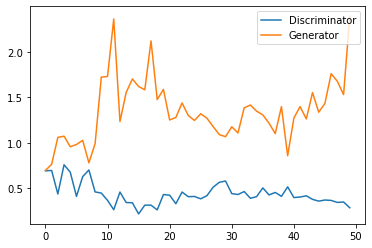

In [6]:
disc = Discriminator(input_features).to(device)
gen = Generator(input_genrator, input_features).to(device)

dataset = DataSet_UNSWNB15_attack_cat("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = opt.Adam(disc.parameters(), lr=lr)
opt_gen = opt.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

d_history = []
g_history = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):

        real = torch.reshape(real, (real.shape[0], 1, real.shape[1]))

        real = real.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, input_genrator).to(device)
        fake = gen(noise)
        fake = torch.reshape(fake, (fake.shape[0], 1, fake.shape[1]))
        # print(real.shape)
        disc_real = disc(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            # print(real,fake)
            print(f"Epoch [{epoch}/{num_epochs}] loss D: {lossD:.4f}, loss G: {lossG:.4f}")
            
    d_history.append(lossD.cpu().detach().numpy().item())
    g_history.append(lossG.cpu().detach().numpy().item())
            # print(d_history)
plot_history(d_history, g_history)

# **label**

Epoch [0/50] loss D: 0.6932, loss G: 0.6820
Epoch [1/50] loss D: 0.4107, loss G: 1.2829
Epoch [2/50] loss D: 0.0533, loss G: 3.2183
Epoch [3/50] loss D: 0.4682, loss G: 1.2530
Epoch [4/50] loss D: 0.6258, loss G: 0.7761
Epoch [5/50] loss D: 0.5749, loss G: 0.8880
Epoch [6/50] loss D: 0.4633, loss G: 1.3522
Epoch [7/50] loss D: 0.6125, loss G: 0.9845
Epoch [8/50] loss D: 0.4890, loss G: 1.0327
Epoch [9/50] loss D: 0.4766, loss G: 1.1056
Epoch [10/50] loss D: 0.4224, loss G: 1.1524
Epoch [11/50] loss D: 0.2530, loss G: 1.7604
Epoch [12/50] loss D: 0.6194, loss G: 1.1128
Epoch [13/50] loss D: 0.4325, loss G: 1.0269
Epoch [14/50] loss D: 0.5991, loss G: 0.8069
Epoch [15/50] loss D: 0.3936, loss G: 1.2631
Epoch [16/50] loss D: 0.2865, loss G: 1.7005
Epoch [17/50] loss D: 0.2378, loss G: 2.0163
Epoch [18/50] loss D: 0.2107, loss G: 2.2936
Epoch [19/50] loss D: 0.3062, loss G: 2.7252
Epoch [20/50] loss D: 0.2912, loss G: 2.0164
Epoch [21/50] loss D: 0.3096, loss G: 1.7648
Epoch [22/50] loss D

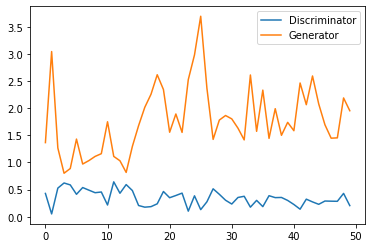

In [7]:
disc = Discriminator(input_features).to(device)
gen = Generator(input_genrator, input_features).to(device)

dataset = DataSet_UNSWNB15_label("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = opt.Adam(disc.parameters(), lr=lr)
opt_gen = opt.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

d_history = []
g_history = []

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):

        real = torch.reshape(real, (real.shape[0], 1, real.shape[1]))
        
        real = real.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, input_genrator).to(device)
        fake = gen(noise)
        fake = torch.reshape(fake, (fake.shape[0], 1, fake.shape[1]))
        # print(real.shape)
        disc_real = disc(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            # print(real,fake)
            print(f"Epoch [{epoch}/{num_epochs}] loss D: {lossD:.4f}, loss G: {lossG:.4f}")
    d_history.append(lossD.cpu().detach().numpy().item())
    g_history.append(lossG.cpu().detach().numpy().item())
            # print(d_history)
plot_history(d_history, g_history)